In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd 
import geopandas as gpd 

import rasterio       # For reading .tif files
import matplotlib.pyplot as plt  # For plotting
import numpy as np
import pdb 
import xarray as xr

import rioxarray as xrio
import cv2

import project3_tools
import importlib

from affine import Affine
from rasterio.transform import from_origin
from rasterio.features import geometry_mask

from scipy import ndimage
from matplotlib.colors import LinearSegmentedColormap, Normalize


In [2]:
def print_raster(raster):
    print(
        f"shape: {raster.rio.shape}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: {raster.rio.bounds()}\n"
        f"sum: {raster.sum().item()}\n"
        f"CRS: {raster.rio.crs}\n"
    )

In [3]:
#load burn area
ba = gpd.read_file('/data/IMFSE/PythonCourse/PontdeVilomara/burntArea/burnAreaPdV2022.shp')

In [4]:
#input files
file_f = '/data/IMFSE/PythonCourse/LCP/lcp_pgd80.tif'
file_atm = '/data/IMFSE/PythonCourse/MNH/FCAST_model3.nc'


In [5]:
#load terrain from fire
ds_f = xrio.open_rasterio(file_f, decode_times=False)
terrain_f = ds_f.isel(band=0)
mask=np.where(terrain_f.values==-9999,0,1).astype(np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_ERODE, np.ones((21,21))) # to remove point on the border
terrain_f.values[np.where(mask==0)]=-9999

terrain_f_ori = terrain_f.copy()
terrain_f_ori.values[np.where(mask==0)]=-9999

In [6]:
#load terrain from atm from netcdf and set topo in xr dataArray with crs 4326
ds_atm = xr.open_dataset(file_atm, decode_times=False)
terrain_atm = ds_atm.topography
lat_atm = ds_atm.lat.values[:,0]
lon_atm = ds_atm.lon.values[0,:]

terrain_atm_wgs= xr.DataArray(
    terrain_atm.values, 
    coords=[("y", lat_atm), ("x", lon_atm)],  # Assign coordinates
    dims=["y", "x"],  # Define dimension names
#    attrs={"crs": "EPSG:4326"}  # Add CRS as an attribute (EPSG:4326 = WGS 84)
)

terrain_atm_wgs = terrain_atm_wgs.rio.write_crs("EPSG:4326",inplace=True)


In [7]:
# Now reproject the terrain_atm_wgs 
#to a the same projection and extdend as terrain_f
terrain_atm = terrain_atm_wgs.rio.reproject_match(terrain_f, nodata=-9999)

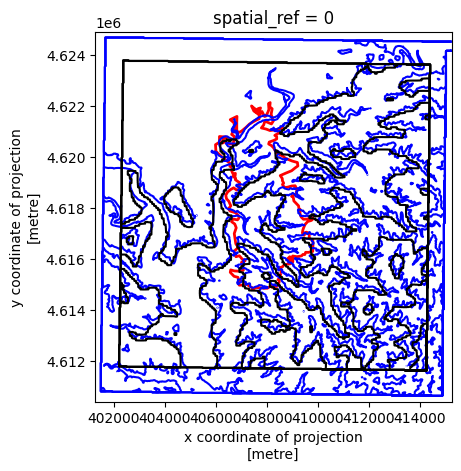

In [8]:
#plot
levels = np.linspace(0, 1000, 10)

ax = plt.subplot(111)
terrain_f.plot.contour(levels=levels,cmap='b',ax=ax)
terrain_atm.plot.contour(levels=levels,ax=ax,cmap='k')
ba.to_crs(ds_f.rio.crs).plot(ax=ax,edgecolor='r', facecolor='none',linewidth=2)
ax.set_aspect(1)

#ax = plt.subplot(122)
#terrain_atm.plot(vmin=0,vmax=1000,ax=ax)
#ba.to_crs(ds_f.rio.crs).plot(ax=ax,edgecolor='k', facecolor='none')
#ax.set_aspect(1)

In [9]:
#############################################
################load SRTM ###################
#############################################

In [10]:
file_srtm = '/data/IMFSE/PythonCourse/LCP/srtm30m_pdV.tif'
#load terrain from fire
ds_srtm = xrio.open_rasterio(file_srtm, decode_times=False)
terrain_srtm = ds_srtm.isel(band=0)
terrain_srtm = terrain_srtm.rio.reproject_match(terrain_f, nodata=-9999)

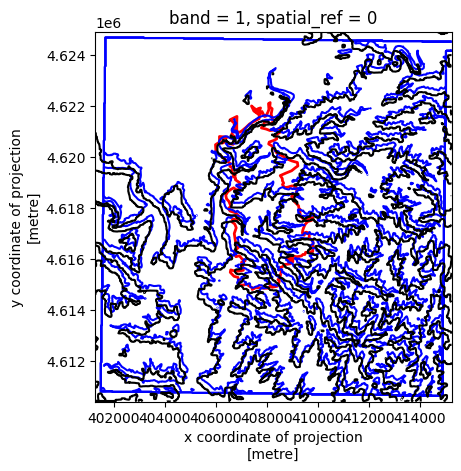

In [11]:
#plot
levels = np.linspace(0, 1000, 10)
ax = plt.subplot(111)
terrain_f.plot.contour(levels=levels,cmap='b',ax=ax)
terrain_srtm.plot.contour(levels=levels,ax=ax,cmap='k')
ba.to_crs(ds_f.rio.crs).plot(ax=ax,edgecolor='r', facecolor='none',linewidth=2)
ax.set_aspect(1)


In [12]:
#############################################
################estimate shift###############
#############################################

In [13]:
importlib.reload(project3_tools)
terrain_f, warp_matrix = project3_tools.aligned_terrain(terrain_f.copy(), terrain_srtm)

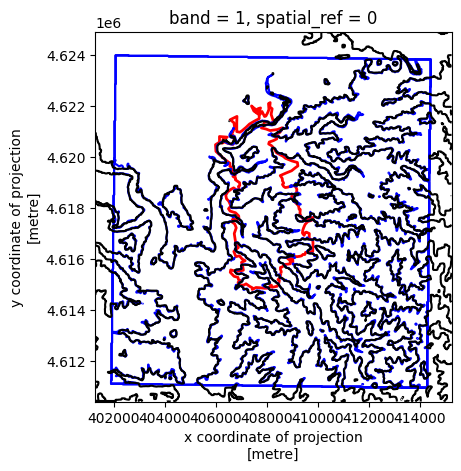

In [14]:
#plot aligned terrain
levels = np.linspace(0, 1000, 10)
ax = plt.subplot(111)
terrain_f.plot.contour(levels=levels,cmap='b',ax=ax)
terrain_srtm.plot.contour(levels=levels,ax=ax,cmap='k')
ba.to_crs(ds_f.rio.crs).plot(ax=ax,edgecolor='r', facecolor='none',linewidth=2)
ax.set_aspect(1)

In [15]:
translation = warp_matrix[:,2] * terrain_srtm.rio.resolution()[0]
print('translation of x={:5.3f} y={:5.3f} m'.format(*translation))

translation of x=92.041 y=-207.072 m


In [16]:
#############################################
################fuelMap in ba###############
#############################################

In [17]:
ds_f

<xarray.DataArray (band: 8, y: 726, x: 700)> Size: 8MB
[4065600 values with dtype=int16]
Coordinates:
  * band         (band) int64 64B 1 2 3 4 5 6 7 8
  * x            (x) float64 6kB 4.013e+05 4.013e+05 ... 4.152e+05 4.152e+05
  * y            (y) float64 6kB 4.625e+06 4.625e+06 ... 4.61e+06 4.61e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999
    scale_factor:   1.0
    add_offset:     0.0

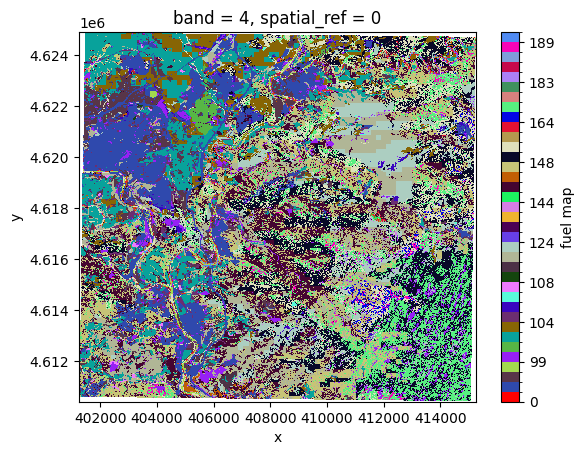

In [18]:
%matplotlib inline
fuelmap_f = ds_f.isel(band=3)
fuelmap_f.name = 'fuel map'

N = len(np.unique(fuelmap_f.values)) -1  # Number of colors
colors = np.random.rand(N, 3) #plt.cm.hsv(np.linspace(0, 1, N))
cmap_fm = mcolors.ListedColormap(colors)
colors[0,:] = [1,0,0]

# Define the boundaries of each color segment
bounds = np.unique(fuelmap_f.values)[1:]  # from 1 to 10
bounds = np.append(bounds, 9999)
norm_fm = mcolors.BoundaryNorm(bounds, cmap_fm.N)

#set no data to not be ploted
nodata_value = -9999
fuelmap_f = fuelmap_f.where(fuelmap_f != nodata_value)

fuelmap_f.plot(cmap=cmap_fm,norm=norm_fm)


In [19]:
maskBa = project3_tools.create_mask_from_ba( fuelmap_f, ba)

In [20]:
masked_da = fuelmap_f.where(maskBa == 1)
gdf_fuelMap = masked_da.to_dataframe().dropna().reset_index().drop(columns=['x','y','band','spatial_ref'])

In [21]:
gdf_fuelMap

,fuel map
0,93.0
1,93.0
2,123.0
3,93.0
4,93.0
...,...
37811,149.0
37812,149.0
37813,149.0
37814,149.0


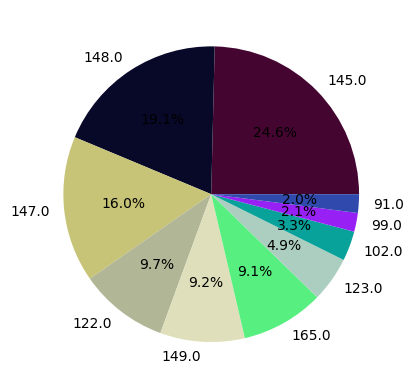

In [22]:
value_counts = gdf_fuelMap['fuel map'].value_counts()

# Plot a pie chart with the top N categories
top_n = 10  # Plot the top 10 most frequent categories
value_counts.head(top_n).plot(kind='pie', autopct='%1.1f%%',colors=cmap_fm(norm_fm(value_counts.index)))

plt.ylabel('')  # Remove y-label for pie chart
plt.show()



In [23]:
#############################################
################aspect vs fuelmap############
#############################################

In [24]:


def compute_aspect_with_projection(dem: xr.DataArray) -> xr.DataArray:
    """
    Compute the aspect from a DEM (Digital Elevation Model) DataArray, retaining
    the projection and coordinate reference system (CRS) information.
    
    Parameters:
    - dem: xarray.DataArray of the elevation data, with spatial coordinates (e.g., 'x', 'y')
    
    Returns:
    - aspect_da: xarray.DataArray of the aspect in degrees (0-360), retaining the same CRS and projection as the input
    """

    # Compute gradients (slopes) in y and x directions
    grad_y, grad_x = np.gradient(dem, dem['y'], dem['x'])

    # Compute aspect using arctan2, with the formula arctan2(grad_x, -grad_y)
    aspect = np.arctan2(grad_x, -grad_y)

    # Convert aspect from radians to degrees and ensure the range is [0, 360]
    aspect = np.degrees(aspect)
    aspect = (aspect + 360) % 360

    # Create a new DataArray with the same coordinates, dimensions, and projection as the input
    aspect_da = xr.DataArray(
        aspect,
        coords=dem.coords,  # Keep the same coordinates
        dims=dem.dims,      # Keep the same dimensions
        attrs=dem.attrs     # Keep the same attributes (projection, CRS, etc.)
    )

    # Update the name and units to reflect that this is the aspect
    aspect_da.name = 'aspect'
    aspect_da.attrs['units'] = 'degrees'
    aspect_da.attrs['description'] = 'Aspect (degrees clockwise from North)'

    return aspect_da

In [25]:
#compute aspect
aspect_f = compute_aspect_with_projection(terrain_f)
aspect_f_ori = compute_aspect_with_projection(terrain_f_ori)

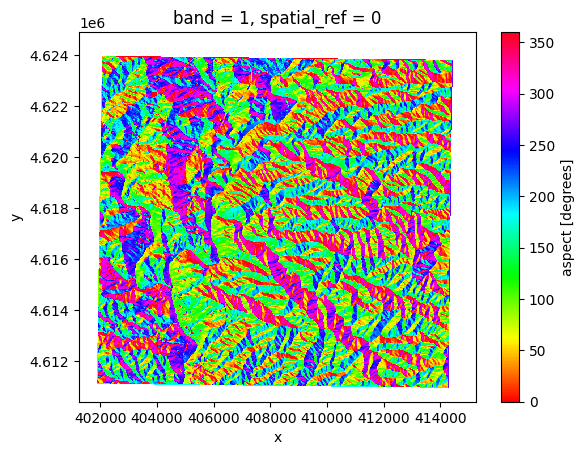

In [26]:
# plot aspect


# Create a colormap
cmap = LinearSegmentedColormap.from_list("red_white_blue", colors, N=256)

# Create a normalization object for the range 0 to 360
norm = Normalize(vmin=0, vmax=360)
aspect_f.where(terrain_f!=-9999).plot(cmap='hsv', vmin=0, vmax=360)

In [27]:
masked_da = aspect_f.where(maskBa == 1)
gdf_aspect = masked_da.to_dataframe().dropna().reset_index().drop(columns=['x','y','band','spatial_ref'])

In [28]:
gdf_aspect

,aspect
0,261.940430
1,265.672546
2,249.891876
3,249.562317
4,250.249100
...,...
37811,223.748505
37812,78.929932
37813,109.740967
37814,160.026062


In [29]:
masked_da = aspect_f_ori.where(maskBa == 1)
gdf_aspect_ori = masked_da.to_dataframe().dropna().reset_index().drop(columns=['x','y','band','spatial_ref'])

In [30]:
gdf_aspect_ori

,aspect
0,33.690068
1,341.565051
2,45.000000
3,71.565051
4,45.000000
...,...
37811,195.255119
37812,142.125016
37813,156.037511
37814,194.036243


In [31]:
merged_df = pd.concat([gdf_fuelMap,gdf_aspect,gdf_aspect_ori], axis=1)

In [32]:
merged_df


,fuel map,aspect,aspect
0,93.0,261.940430,33.690068
1,93.0,265.672546,341.565051
2,123.0,249.891876,45.000000
3,93.0,249.562317,71.565051
4,93.0,250.249100,45.000000
...,...,...,...
37811,149.0,223.748505,195.255119
37812,149.0,78.929932,142.125016
37813,149.0,109.740967,156.037511
37814,149.0,160.026062,194.036243


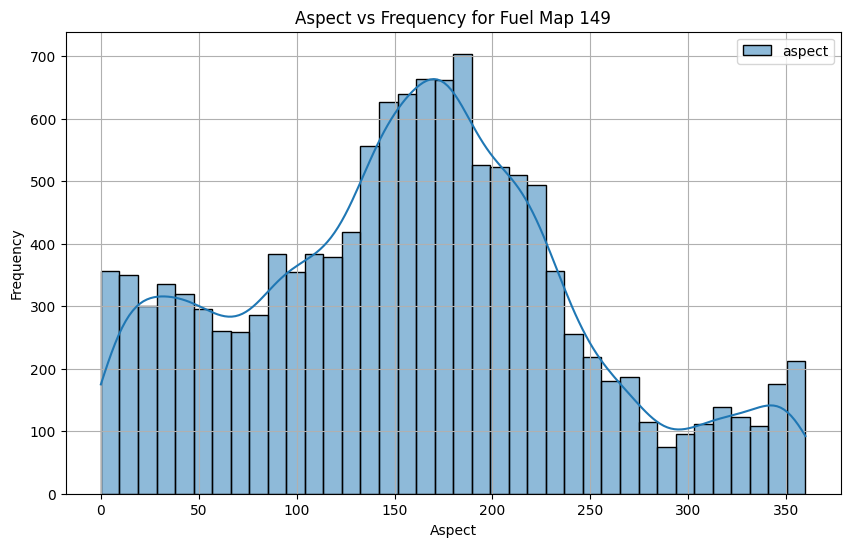

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have the merged_df DataFrame
# Filter the DataFrame for the fuel map value 149
subset = merged_df[merged_df['fuel map'] == 149]

# Create a histogram for the 'aspect' column
plt.figure(figsize=(10, 6))
sns.histplot(subset['aspect'], kde=True, color='g')
plt.title('Aspect vs Frequency for Fuel Map 149')
plt.xlabel('Aspect')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


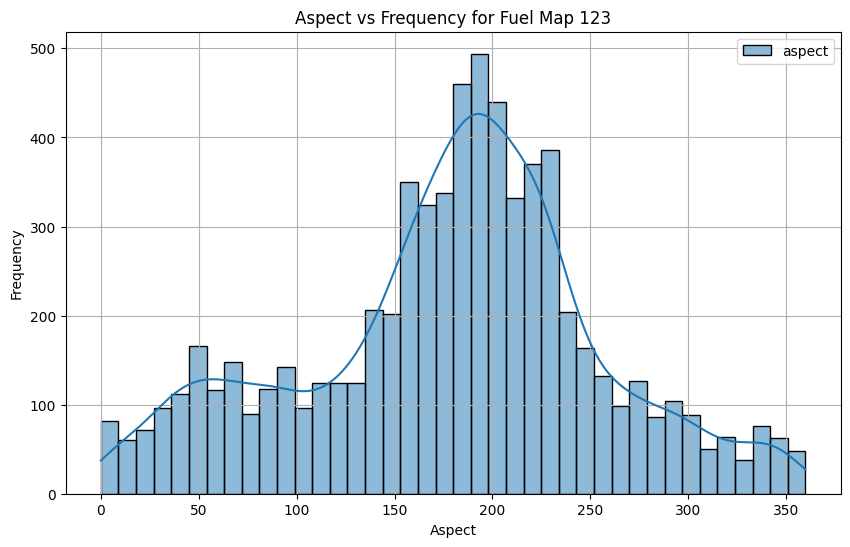

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have the merged_df DataFrame
# Filter the DataFrame for the fuel map value 123
subset = merged_df[merged_df['fuel map'] == 123]

# Create a histogram for the 'aspect' column
plt.figure(figsize=(10, 6))
sns.histplot(subset['aspect'], kde=True, color='g')
plt.title('Aspect vs Frequency for Fuel Map 123')
plt.xlabel('Aspect')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


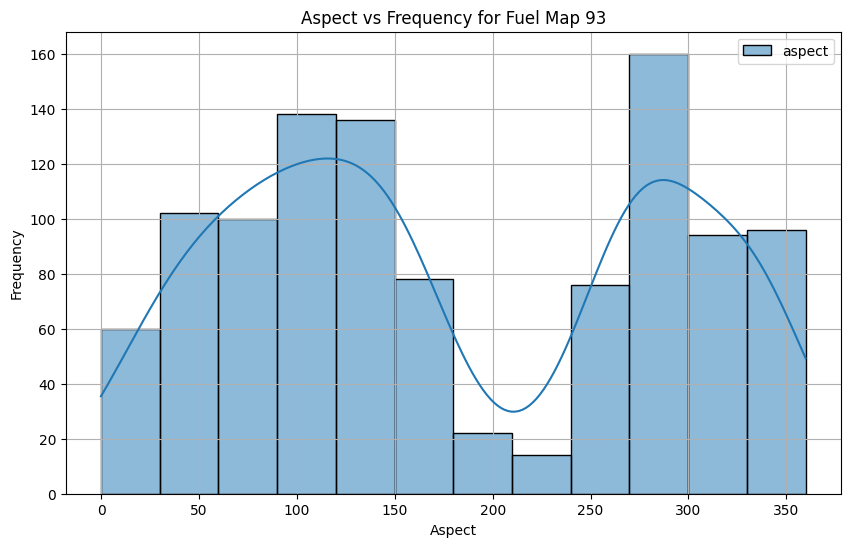

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have the merged_df DataFrame
# Filter the DataFrame for the fuel map value 93
subset = merged_df[merged_df['fuel map'] == 93]

# Create a histogram for the 'aspect' column
plt.figure(figsize=(10, 6))
sns.histplot(subset['aspect'], kde=True, color='blue')
plt.title('Aspect vs Frequency for Fuel Map 93')
plt.xlabel('Aspect')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [37]:
#####below this gpt#####

In [ ]:
# Flatten the masked fuel map to a 1D array
fuelmap_1D = masked_da.values.flatten()

# Compute aspect for aspect_f
elevation_f = aspect_f.values
gradient_y_f, gradient_x_f = np.gradient(elevation_f)
aspect_f_ = np.arctan2(-gradient_x_f, gradient_y_f)
aspect_f_ = np.degrees(aspect_f_)
aspect_f_ = (aspect_f_ + 360) % 360  # Ensure aspect is between 0 and 360
aspect_f_1D = aspect_f_.flatten()

# Compute aspect for aspect_f_ori
elevation_f_ori = aspect_f_ori.values
gradient_y_f_ori, gradient_x_f_ori = np.gradient(elevation_f_ori)
aspect_f_ori_ = np.arctan2(-gradient_x_f_ori, gradient_y_f_ori)
aspect_f_ori_ = np.degrees(aspect_f_ori_)
aspect_f_ori_ = (aspect_f_ori_ + 360) % 360  # Ensure aspect is between 0 and 360
aspect_f_ori_1D = aspect_f_ori_.flatten()

# Filter out NaN values from the fuel map for both comparisons
valid_fuelmap = fuelmap_1D[~np.isnan(fuelmap_1D)]

# For aspect_f
valid_aspect_f = aspect_f_1D[~np.isnan(fuelmap_1D)]
correlation_f = np.corrcoef(valid_aspect_f, valid_fuelmap)[0, 1]
print(f"Correlation between aspect_f and fuel types: {correlation_f}")

# For aspect_f_ori
valid_aspect_f_ori = aspect_f_ori_1D[~np.isnan(fuelmap_1D)]
correlation_f_ori = np.corrcoef(valid_aspect_f_ori, valid_fuelmap)[0, 1]
print(f"Correlation between aspect_f_ori and fuel types: {correlation_f_ori}")


In [ ]:
# Assuming fuelmap_f and masked_da are already defined and filtered to 1D as earlier
fuelmap_1D = masked_da.values.flatten()

# Compute aspect for aspect_f
elevation_f = aspect_f.values
gradient_y_f, gradient_x_f = np.gradient(elevation_f)
aspect_f_ = np.arctan2(-gradient_x_f, gradient_y_f)
aspect_f_ = np.degrees(aspect_f_)
aspect_f_ = (aspect_f_ + 360) % 360  # Ensure aspect is between 0 and 360
aspect_f_1D = aspect_f_.flatten()

# Compute aspect for aspect_f_ori
elevation_f_ori = aspect_f_ori.values
gradient_y_f_ori, gradient_x_f_ori = np.gradient(elevation_f_ori)
aspect_f_ori_ = np.arctan2(-gradient_x_f_ori, gradient_y_f_ori)
aspect_f_ori_ = np.degrees(aspect_f_ori_)
aspect_f_ori_ = (aspect_f_ori_ + 360) % 360  # Ensure aspect is between 0 and 360
aspect_f_ori_1D = aspect_f_ori_.flatten()

# Filter out NaN values from the fuel map for both aspects
valid_fuelmap = fuelmap_1D[~np.isnan(fuelmap_1D)]
valid_aspect_f = aspect_f_1D[~np.isnan(fuelmap_1D)]
valid_aspect_f_ori = aspect_f_ori_1D[~np.isnan(fuelmap_1D)]

# Create a DataFrame with fuel map, aspect_f, and aspect_f_ori
df_comparison = pd.DataFrame({
    'fuel_map': valid_fuelmap,
    'aspect_f': valid_aspect_f,
    'aspect_f_ori': valid_aspect_f_ori
})

# Display the first few rows for verification
print(df_comparison.head())


In [ ]:
# Assuming valid_aspect_f, valid_aspect_f_ori, and valid_fuelmap are already filtered

# Create a DataFrame with the fuel map and the two aspect columns
gdf_fuelMap = pd.DataFrame({
    'fuel map': valid_fuelmap,
    'aspect_f': valid_aspect_f,
    'aspect_f_ori': valid_aspect_f_ori
})

# Display the DataFrame to check the first few rows
gdf_fuelMap.head()


In [ ]:
import matplotlib.pyplot as plt

# Get the top N fuel map categories based on their frequency
value_counts = gdf_fuelMap['fuel map'].value_counts()
top_n = 10  # Let's plot the top 10 categories by default

# Create a color map to be consistent with the earlier visualization
colors = cmap_fm(norm_fm(value_counts.index))

# Set up the figure for subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Fuel map distribution (Pie chart)
gdf_fuelMap['fuel map'].value_counts().head(top_n).plot(kind='pie', autopct='%1.1f%%', colors=colors, ax=axes[0])
axes[0].set_ylabel('')  # Remove the y-label for better clarity
axes[0].set_title('Fuel Map Distribution')

# Plot 2: Distribution of aspect_f with respect to the fuel type
gdf_fuelMap.groupby('fuel map')['aspect_f'].mean().head(top_n).plot(kind='bar', color=colors, ax=axes[1])
axes[1].set_title('Aspect_f vs. Fuel Map')
axes[1].set_xlabel('Fuel Map Type')
axes[1].set_ylabel('Mean Aspect_f (degrees)')

# Plot 3: Distribution of aspect_f_ori with respect to the fuel type
gdf_fuelMap.groupby('fuel map')['aspect_f_ori'].mean().head(top_n).plot(kind='bar', color=colors, ax=axes[2])
axes[2].set_title('Aspect_f_ori vs. Fuel Map')
axes[2].set_xlabel('Fuel Map Type')
axes[2].set_ylabel('Mean Aspect_f_ori (degrees)')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()
